# 功夫動作分類 - 深度學習模型訓練

使用 **PyTorch** 建立深度神經網路 (DNN) 來辨識 4 種功夫動作：
- act1: 握拳式 (Fist)
- act2: 出拳式 (Punch)
- act3: 踢腿式 (Kick)
- act4: 提膝式 (Knee)

## 模型架構
- 輸入層: 6 個關節角度特徵
- 隱藏層: 多層全連接層 + BatchNorm + Dropout
- 輸出層: 4 個類別

## 1. 匯入套件

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

# Sklearn (僅用於資料預處理和評估)
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import warnings
warnings.filterwarnings('ignore')

# 設定中文字體
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei', 'SimHei', 'Arial']
plt.rcParams['axes.unicode_minus'] = False

# 檢查 GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用裝置: {device}")
print(f"PyTorch 版本: {torch.__version__}")

使用裝置: cuda
PyTorch 版本: 2.9.1+cu128


## 2. 讀取與探索資料

In [2]:
# 讀取 CSV 檔案
csv_path = './dataset/pose_angles_summary_actual.csv'
df = pd.read_csv(csv_path)

print(f"總樣本數: {len(df)}")
print(f"欄位: {list(df.columns)}")
print(f"\n各動作類型數量:")
print(df['Action_Type'].value_counts())

df.head()

總樣本數: 265
欄位: ['File_Name', 'R_Elbow_Angle', 'L_Elbow_Angle', 'R_Knee_Angle', 'L_Knee_Angle', 'R_Hip_Angle', 'L_Hip_Angle', 'Action_Type']

各動作類型數量:
Action_Type
act4    74
act1    67
act2    63
act3    61
Name: count, dtype: int64


,File_Name,R_Elbow_Angle,L_Elbow_Angle,R_Knee_Angle,L_Knee_Angle,R_Hip_Angle,L_Hip_Angle,Action_Type
0,act1_fist_p1_1.jpg,137.487037,170.097797,178.167124,178.146972,174.201098,170.743464,act1
1,act1_fist_p1_2.jpg,138.871202,158.591052,174.922449,174.665972,170.414440,171.644344,act1
2,act1_fist_p1_3.jpg,150.922331,142.812249,169.861679,168.919561,166.255170,171.794513,act1
3,act1_fist_p1_4.jpg,152.429005,133.641754,169.501889,173.723058,166.997450,167.376224,act1
4,act1_fist_p1_5.jpg,177.401274,128.472869,172.466703,172.247792,171.033392,169.443375,act1


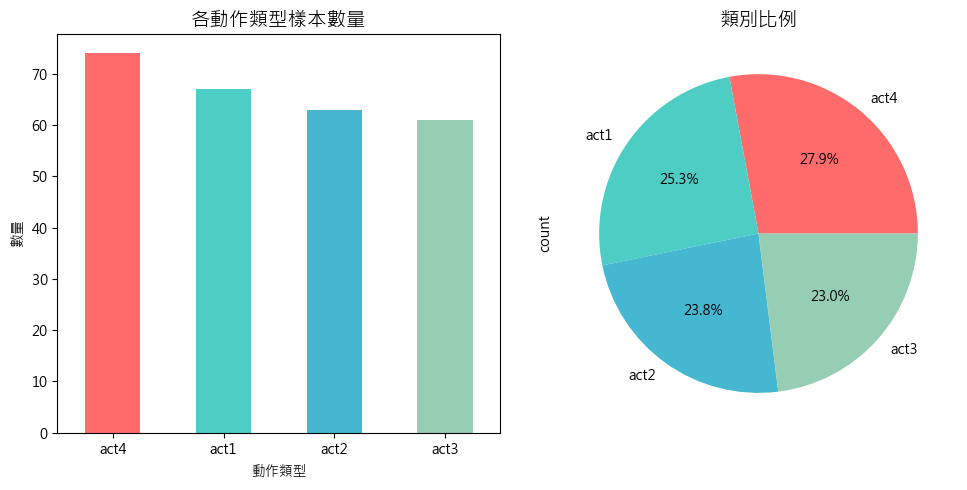

In [3]:
# 視覺化類別分布
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
df['Action_Type'].value_counts().plot(kind='bar', color=colors)
plt.title('各動作類型樣本數量', fontsize=14)
plt.xlabel('動作類型')
plt.ylabel('數量')
plt.xticks(rotation=0)

plt.subplot(1, 2, 2)
df['Action_Type'].value_counts().plot(kind='pie', colors=colors, autopct='%1.1f%%')
plt.title('類別比例', fontsize=14)

plt.tight_layout()
plt.show()

## 3. 資料預處理

In [4]:
# 定義特徵欄位
feature_columns = [
    'R_Elbow_Angle', 'L_Elbow_Angle',
    'R_Knee_Angle', 'L_Knee_Angle',
    'R_Hip_Angle', 'L_Hip_Angle'
]

# 準備特徵和標籤
X = df[feature_columns].values
y = df['Action_Type'].values

print(f"特徵維度: {X.shape}")
print(f"標籤數量: {len(y)}")

特徵維度: (265, 6)
標籤數量: 265


In [5]:
# 標籤編碼
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print("動作類別對應:")
for i, label in enumerate(label_encoder.classes_):
    print(f"  {label} -> {i}")

num_classes = len(label_encoder.classes_)
print(f"\n類別數量: {num_classes}")

動作類別對應:
  act1 -> 0
  act2 -> 1
  act3 -> 2
  act4 -> 3

類別數量: 4


In [6]:
# 標準化特徵
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("標準化後的特徵統計:")
print(f"平均值: {X_scaled.mean(axis=0).round(4)}")
print(f"標準差: {X_scaled.std(axis=0).round(4)}")

標準化後的特徵統計:
平均值: [-0.  0.  0.  0. -0.  0.]
標準差: [1. 1. 1. 1. 1. 1.]


## 4. 建立 PyTorch Dataset

In [7]:
class KungfuDataset(Dataset):
    """功夫動作資料集"""
    
    def __init__(self, features, labels):
        self.features = torch.FloatTensor(features)
        self.labels = torch.LongTensor(labels)
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# 建立完整資料集
full_dataset = KungfuDataset(X_scaled, y_encoded)
print(f"資料集大小: {len(full_dataset)}")

資料集大小: 265


In [8]:
# 分割資料集: 70% 訓練, 15% 驗證, 15% 測試
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, 
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

print(f"訓練集: {len(train_dataset)}")
print(f"驗證集: {len(val_dataset)}")
print(f"測試集: {len(test_dataset)}")

訓練集: 185
驗證集: 39
測試集: 41


In [9]:
# 建立 DataLoader
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"訓練 batches: {len(train_loader)}")
print(f"驗證 batches: {len(val_loader)}")
print(f"測試 batches: {len(test_loader)}")

訓練 batches: 12
驗證 batches: 3
測試 batches: 3


## 5. 定義深度學習模型

In [10]:
class KungfuClassifierDNN(nn.Module):
    """
    功夫動作分類深度神經網路
    
    架構:
    - 輸入層: 6 個特徵 (關節角度)
    - 隱藏層 1: 64 神經元 + BatchNorm + ReLU + Dropout
    - 隱藏層 2: 128 神經元 + BatchNorm + ReLU + Dropout
    - 隱藏層 3: 64 神經元 + BatchNorm + ReLU + Dropout
    - 隱藏層 4: 32 神經元 + BatchNorm + ReLU
    - 輸出層: 4 個類別
    """
    
    def __init__(self, input_size=6, num_classes=4, dropout_rate=0.3):
        super(KungfuClassifierDNN, self).__init__()
        
        self.network = nn.Sequential(
            # 隱藏層 1
            nn.Linear(input_size, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            
            # 隱藏層 2
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            
            # 隱藏層 3
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            
            # 隱藏層 4
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            
            # 輸出層
            nn.Linear(32, num_classes)
        )
    
    def forward(self, x):
        return self.network(x)

# 建立模型
model = KungfuClassifierDNN(input_size=6, num_classes=num_classes).to(device)
print(model)

KungfuClassifierDNN(
  (network): Sequential(
    (0): Linear(in_features=6, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=128, out_features=64, bias=True)
    (9): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=64, out_features=32, bias=True)
    (13): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Linear(in_features=32, out_features=4, bias=True)
  )
)


In [11]:
# 計算模型參數量
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"總參數量: {total_params:,}")
print(f"可訓練參數量: {trainable_params:,}")

總參數量: 19,812
可訓練參數量: 19,812


## 6. 定義損失函數與優化器

In [12]:
# 損失函數: CrossEntropyLoss (適用於多類別分類)
criterion = nn.CrossEntropyLoss()

# 優化器: Adam
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

# 學習率調度器: 當驗證損失不再下降時，降低學習率
# 注意: PyTorch 2.x 移除了 verbose 參數
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=10
)

print(f"損失函數: CrossEntropyLoss")
print(f"優化器: Adam (lr={learning_rate})")
print(f"學習率調度: ReduceLROnPlateau")

損失函數: CrossEntropyLoss
優化器: Adam (lr=0.001)
學習率調度: ReduceLROnPlateau


## 7. 訓練模型

In [13]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    """訓練一個 epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for features, labels in train_loader:
        features, labels = features.to(device), labels.to(device)
        
        # 前向傳播
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        
        # 反向傳播
        loss.backward()
        optimizer.step()
        
        # 統計
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


def validate(model, val_loader, criterion, device):
    """驗證模型"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for features, labels in val_loader:
            features, labels = features.to(device), labels.to(device)
            
            outputs = model(features)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(val_loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

In [14]:
# 訓練參數
num_epochs = 100
best_val_acc = 0.0
patience = 20
patience_counter = 0

# 記錄訓練過程
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

print("開始訓練...")
print("=" * 60)

for epoch in range(num_epochs):
    # 訓練
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # 驗證
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    
    # 更新學習率
    scheduler.step(val_loss)
    
    # 記錄
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # 儲存最佳模型
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), './model/kungfu_dnn_best.pth')
        patience_counter = 0
        best_marker = ' *'
    else:
        patience_counter += 1
        best_marker = ''
    
    # 顯示進度
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1:3d}/{num_epochs}] "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}{best_marker}")
    
    # Early stopping
    if patience_counter >= patience:
        print(f"\nEarly stopping at epoch {epoch+1}")
        break

print("=" * 60)
print(f"訓練完成！最佳驗證準確度: {best_val_acc:.4f}")

開始訓練...
Epoch [  1/100] Train Loss: 1.3220, Train Acc: 0.3135 | Val Loss: 1.2974, Val Acc: 0.2308 *
Epoch [ 10/100] Train Loss: 0.4785, Train Acc: 0.8649 | Val Loss: 0.2350, Val Acc: 0.9744
Epoch [ 20/100] Train Loss: 0.2977, Train Acc: 0.9081 | Val Loss: 0.1612, Val Acc: 0.9744

Early stopping at epoch 23
訓練完成！最佳驗證準確度: 0.9744


## 8. 視覺化訓練過程

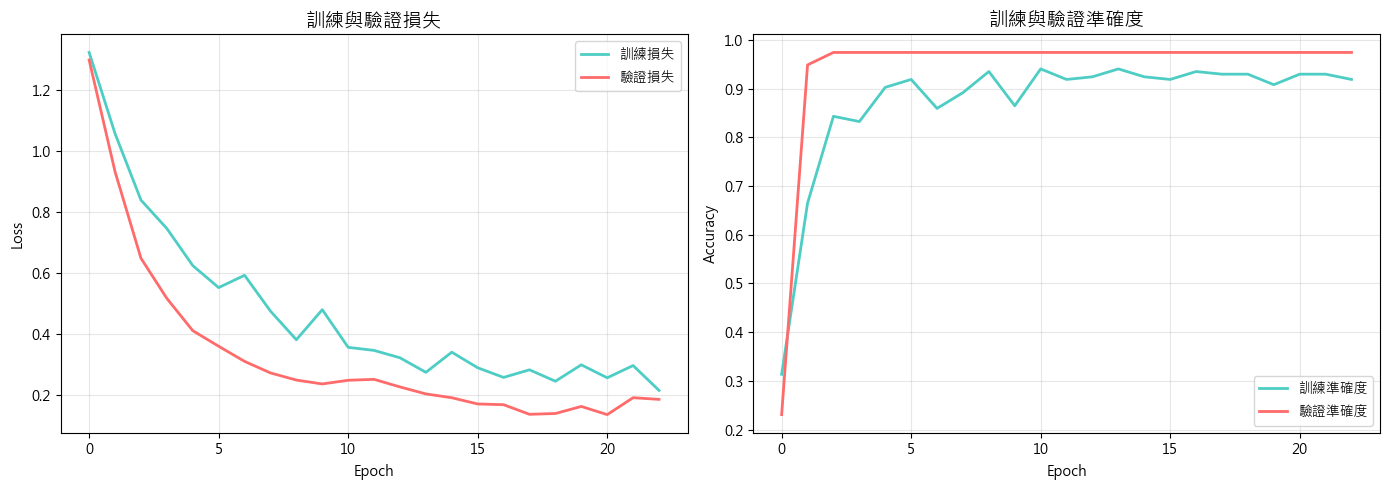

訓練曲線已儲存至 ./model/training_curves.png


In [15]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 損失曲線
axes[0].plot(history['train_loss'], label='訓練損失', color='#4ECDC4', linewidth=2)
axes[0].plot(history['val_loss'], label='驗證損失', color='#FF6B6B', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('訓練與驗證損失', fontsize=14)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 準確度曲線
axes[1].plot(history['train_acc'], label='訓練準確度', color='#4ECDC4', linewidth=2)
axes[1].plot(history['val_acc'], label='驗證準確度', color='#FF6B6B', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('訓練與驗證準確度', fontsize=14)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('./model/training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print("訓練曲線已儲存至 ./model/training_curves.png")

## 9. 測試集評估

In [16]:
# 載入最佳模型
model.load_state_dict(torch.load('./model/kungfu_dnn_best.pth'))
model.eval()

# 收集預測結果
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for features, labels in test_loader:
        features = features.to(device)
        outputs = model(features)
        probs = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())
        all_probs.extend(probs.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

In [17]:
# 計算測試準確度
test_accuracy = accuracy_score(all_labels, all_preds)
print(f"測試集準確度: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

# 詳細分類報告
print("\n【分類報告】")
print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))

測試集準確度: 0.8780 (87.80%)

【分類報告】
              precision    recall  f1-score   support

        act1       1.00      1.00      1.00        11
        act2       0.79      0.85      0.81        13
        act3       0.75      0.67      0.71         9
        act4       1.00      1.00      1.00         8

    accuracy                           0.88        41
   macro avg       0.88      0.88      0.88        41
weighted avg       0.88      0.88      0.88        41



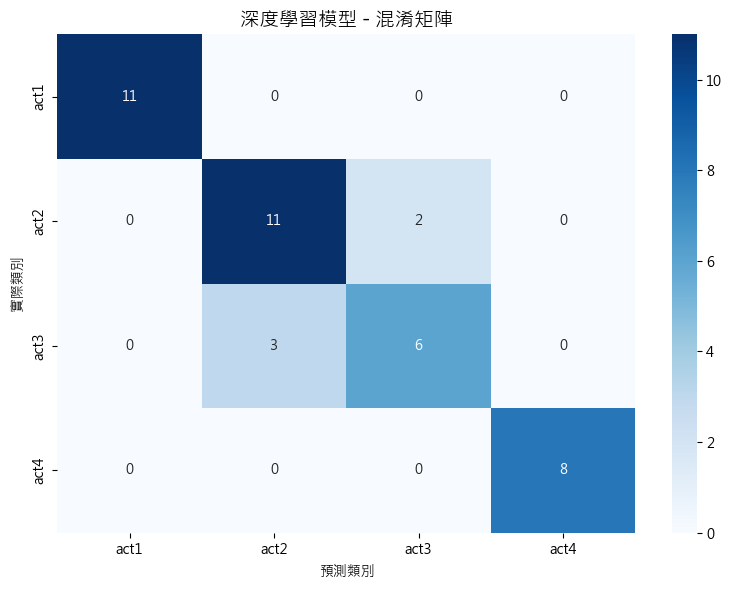

混淆矩陣已儲存至 ./model/confusion_matrix.png


In [18]:
# 混淆矩陣
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('深度學習模型 - 混淆矩陣', fontsize=14)
plt.xlabel('預測類別')
plt.ylabel('實際類別')
plt.tight_layout()
plt.savefig('./model/confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print("混淆矩陣已儲存至 ./model/confusion_matrix.png")

## 10. 儲存模型與相關檔案

In [19]:
import joblib

# 確保 model 資料夾存在
save_path = Path('./model')
save_path.mkdir(parents=True, exist_ok=True)

# 1. 儲存完整模型 (包含架構)
torch.save(model, save_path / 'kungfu_dnn_full.pth')
print(f"完整模型已儲存: {save_path / 'kungfu_dnn_full.pth'}")

# 2. 儲存模型權重
torch.save(model.state_dict(), save_path / 'kungfu_dnn_weights.pth')
print(f"模型權重已儲存: {save_path / 'kungfu_dnn_weights.pth'}")

# 3. 儲存 scaler
joblib.dump(scaler, save_path / 'scaler.joblib')
print(f"Scaler 已儲存: {save_path / 'scaler.joblib'}")

# 4. 儲存 label encoder
joblib.dump(label_encoder, save_path / 'label_encoder.joblib')
print(f"Label Encoder 已儲存: {save_path / 'label_encoder.joblib'}")

# 5. 儲存模型資訊
model_info = {
    'model_type': 'PyTorch DNN',
    'input_size': 6,
    'num_classes': num_classes,
    'feature_columns': feature_columns,
    'classes': list(label_encoder.classes_),
    'test_accuracy': test_accuracy,
    'architecture': str(model)
}
joblib.dump(model_info, save_path / 'model_info.joblib')
print(f"模型資訊已儲存: {save_path / 'model_info.joblib'}")

print(f"\n所有檔案已儲存至: {save_path.absolute()}")

完整模型已儲存: model\kungfu_dnn_full.pth
模型權重已儲存: model\kungfu_dnn_weights.pth
Scaler 已儲存: model\scaler.joblib
Label Encoder 已儲存: model\label_encoder.joblib
模型資訊已儲存: model\model_info.joblib

所有檔案已儲存至: c:\Users\User\deskTop-1\fcu114-1\KungFu-master\model


## 11. 測試推論

In [20]:
def predict_action(model, scaler, label_encoder, angles_dict, device):
    """
    預測功夫動作
    
    參數:
        model: PyTorch 模型
        scaler: 特徵標準化器
        label_encoder: 標籤編碼器
        angles_dict: 包含 6 個角度的字典
        device: 運算裝置
    
    回傳:
        (動作代碼, 各類別機率)
    """
    model.eval()
    
    # 準備輸入
    feature_columns = ['R_Elbow_Angle', 'L_Elbow_Angle', 'R_Knee_Angle', 
                       'L_Knee_Angle', 'R_Hip_Angle', 'L_Hip_Angle']
    X = np.array([[angles_dict[col] for col in feature_columns]])
    X_scaled = scaler.transform(X)
    X_tensor = torch.FloatTensor(X_scaled).to(device)
    
    # 預測
    with torch.no_grad():
        outputs = model(X_tensor)
        probs = torch.softmax(outputs, dim=1).cpu().numpy()[0]
        pred_idx = outputs.argmax(dim=1).cpu().numpy()[0]
    
    predicted_class = label_encoder.inverse_transform([pred_idx])[0]
    prob_dict = dict(zip(label_encoder.classes_, probs))
    
    return predicted_class, prob_dict

In [24]:
# 測試範例: 踢腿式
test_angles_kick = {
    'R_Elbow_Angle': 155.0,
    'L_Elbow_Angle': 40.0,
    'R_Knee_Angle': 164.0,
    'L_Knee_Angle': 168.0,
    'R_Hip_Angle': 176.0,
    'L_Hip_Angle': 125.0
}

action_names = {
    'act1': '握拳式 (Fist)',
    'act2': '出拳式 (Punch)',
    'act3': '踢腿式 (Kick)',
    'act4': '提膝式 (Knee)'
}

predicted, probs = predict_action(model, scaler, label_encoder, test_angles_kick, device)

print("【測試: 踢腿式角度】")
print(f"預測結果: {action_names.get(predicted, predicted)}")
print(f"\n各類別機率:")
for action, prob in sorted(probs.items(), key=lambda x: x[1], reverse=True):
    name = action_names.get(action, action)
    bar = "█" * int(prob * 30)
    print(f"  {name}: {prob:.2%} {bar}")

【測試: 踢腿式角度】
預測結果: 踢腿式 (Kick)

各類別機率:
  踢腿式 (Kick): 50.34% ███████████████
  握拳式 (Fist): 22.22% ██████
  出拳式 (Punch): 15.89% ████
  提膝式 (Knee): 11.55% ███


In [23]:
# 測試範例: 出拳式
test_angles_punch = {
    'R_Elbow_Angle': 170.0,
    'L_Elbow_Angle': 55.0,
    'R_Knee_Angle': 125.0,
    'L_Knee_Angle': 150.0,
    'R_Hip_Angle': 150.0,
    'L_Hip_Angle': 145.0
}

predicted, probs = predict_action(model, scaler, label_encoder, test_angles_punch, device)

print("【測試: 出拳式角度】")
print(f"預測結果: {action_names.get(predicted, predicted)}")
print(f"\n各類別機率:")
for action, prob in sorted(probs.items(), key=lambda x: x[1], reverse=True):
    name = action_names.get(action, action)
    bar = "█" * int(prob * 30)
    print(f"  {name}: {prob:.2%} {bar}")

【測試: 出拳式角度】
預測結果: 出拳式 (Punch)

各類別機率:
  出拳式 (Punch): 70.17% █████████████████████
  踢腿式 (Kick): 10.96% ███
  握拳式 (Fist): 10.15% ███
  提膝式 (Knee): 8.71% ██


## 12. 總結

### 模型架構
```
輸入層 (6) -> 全連接層 (64) -> BatchNorm -> ReLU -> Dropout
          -> 全連接層 (128) -> BatchNorm -> ReLU -> Dropout
          -> 全連接層 (64) -> BatchNorm -> ReLU -> Dropout
          -> 全連接層 (32) -> BatchNorm -> ReLU
          -> 輸出層 (4)
```

### 訓練技術
- **優化器**: Adam + Weight Decay (L2 正則化)
- **學習率調度**: ReduceLROnPlateau
- **正則化**: Dropout + BatchNorm
- **Early Stopping**: 防止過擬合

### 儲存的檔案
- `model/kungfu_dnn_full.pth` - 完整 PyTorch 模型
- `model/kungfu_dnn_weights.pth` - 模型權重
- `model/kungfu_dnn_best.pth` - 最佳模型權重
- `model/scaler.joblib` - 特徵標準化器
- `model/label_encoder.joblib` - 標籤編碼器
- `model/model_info.joblib` - 模型資訊
- `model/training_curves.png` - 訓練曲線圖
- `model/confusion_matrix.png` - 混淆矩陣圖